In [20]:
import geopandas as gpd
import pandas as pd


In [14]:
paris_16 = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=75116.geojson')
paris_17 = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=75117.geojson')
boulogne_billancourt = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=92012.geojson')
clichy = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=92024.geojson')
levallois_perret = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=92044.geojson')
neuilly_sur_seine = gpd.read_file('/home/onyxia/work/projet-python-2A/data/dvf/cluster_ouest/data_code_insee=92051.geojson')

Après avoir importé l'ensemble des dataframes, on concatène l'ensemble des dataframes dans "zone_ouest".

In [ ]:
# Ajouter une colonne "ville" dans chaque DataFrame
paris_16['ville'] = 'Paris 16'
paris_17['ville'] = 'Paris 17'
boulogne_billancourt['ville'] = 'Boulogne-Billancourt'
clichy['ville'] = 'Clichy'
levallois_perret['ville'] = 'Levallois-Perret'
neuilly_sur_seine['ville'] = 'Neuilly-sur-Seine'

# Concaténation dans un seul DataFrame
zone_ouest = pd.concat(
    [paris_16, paris_17, boulogne_billancourt, clichy, levallois_perret, neuilly_sur_seine],
    ignore_index=True
)

# Vérifions les dimensions et un aperçu du DataFrame final
print(zone_ouest.shape)
print(zone_ouest.head())


(134410, 24)
                         idmutinvar                        idopendata  \
0  c472cf139b61744cfd6e9d03be7f253a  c472cf139b61744cfd6e9d03be7f253a   
1  0a30b54af952ed9e209e48672f8c9f0b  0a30b54af952ed9e209e48672f8c9f0b   
2  7fbe9e3f3316caafc3c590a65a5cac4a  7fbe9e3f3316caafc3c590a65a5cac4a   
3  6f918277d196129669e45718f214b969  6f918277d196129669e45718f214b969   
4  5b1353b6ffeaeaffbeadb29d4d00d340  5b1353b6ffeaeaffbeadb29d4d00d340   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-04-10     2024     75     Vente  False  120000.00      1      75116   
1 2024-06-04     2024     75     Vente  False  500000.00      1      75116   
2 2024-05-29     2024     75     Vente  False  844000.00      1      75116   
3 2024-03-22     2024     75     Vente  False   19000.00      1      75116   
4 2024-06-10     2024     75     Vente  False  122000.00      1      75116   

   ... sterr nbvolmut nblocmut                            l_idlocmut  sbati  \


In [117]:
# Conversion des colonnes en type float
zone_ouest['valeurfonc'] = pd.to_numeric(zone_ouest['valeurfonc'], errors='coerce')
zone_ouest['nbparmut'] = pd.to_numeric(zone_ouest['nbparmut'], errors='coerce')
zone_ouest['sbati'] = pd.to_numeric(zone_ouest['sbati'], errors='coerce')

# Vérifions les conversions
print(zone_ouest[['valeurfonc', 'sbati']].dtypes)
print(zone_ouest[['valeurfonc', 'sbati']].describe())




valeurfonc    float64
sbati         float64
dtype: object
         valeurfonc         sbati
count  9.259300e+04  92593.000000
mean   6.613468e+05     66.525817
std    6.220068e+05     47.395882
min    1.000000e+03     10.000000
25%    2.900000e+05     34.000000
50%    4.800000e+05     55.000000
75%    8.250000e+05     85.000000
max    2.850000e+07   1469.000000


On décide de garder seulement les appartements et les maisons ayant une valeur foncière et une surface bâtie non nulles.

In [119]:
# Supprimer les lignes avec des valeurs nulles ou aberrantes
zone_ouest = zone_ouest[(zone_ouest['valeurfonc'] > 0) & (zone_ouest['sbati'] > 0)]

# Filtrer les types de biens pertinents
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
zone_ouest = zone_ouest[zone_ouest['libtypbien'].isin(biens_retenus)]

# Vérifions les dimensions et un aperçu
print(zone_ouest.shape)
print(zone_ouest[['valeurfonc', 'sbati', 'libtypbien']].head())



(92593, 33)
   valeurfonc  sbati      libtypbien
1    500000.0   38.0  UN APPARTEMENT
2    844000.0   59.0  UN APPARTEMENT
6    185000.0   25.0  UN APPARTEMENT
8    632950.0   51.0  UN APPARTEMENT
9   1720000.0  136.0  UN APPARTEMENT


On calcule le prix au m²

In [120]:
# Calcul du prix au m²
zone_ouest['prix_m2'] = zone_ouest['valeurfonc'] / zone_ouest['surface']

# Vérifions un aperçu des données
print(zone_ouest[['valeurfonc', 'surface', 'prix_m2']].head())


   valeurfonc  surface       prix_m2
1    500000.0       38  13157.894737
2    844000.0       59  14305.084746
6    185000.0       25   7400.000000
8    632950.0       51  12410.784314
9   1720000.0      136  12647.058824


On supprime les valeurs aberrantes du prix au mètre carré en définissant une échelle entre 500 et 50 000 euros.

In [ ]:

zone_ouest = zone_ouest[(zone_ouest['prix_m2'] >= 500) & (zone_ouest['prix_m2'] <= 50000)]

# Vérifions les dimensions après filtrage
print(zone_ouest.shape)


(92593, 26)


On décide de réaliser une catégorie une analyse statistique par catégorie de surface en définisasant très petite surface correspondant à un studio ou un T1, petite à moyenne surface (T2/T3), et plus grande surface

In [ ]:
bins = [0, 35, 60, 80, float('inf')]

labels = [
    "Très petite surface (0-35 m²)",
    "Petite à moyenne (35-60 m²)",
    "Moyenne à grande (60-80 m²)",
    "Grande surface (80 m²+)"
]

zone_ouest['categorie_surface'] = pd.cut(
    zone_ouest['surface'], 
    bins=bins, 
    labels=labels, 
    right=True  

zone_ouest[['surface', 'categorie_surface']].head(10)


,surface,categorie_surface
1,38,Petite à moyenne (35-60 m²)
2,59,Petite à moyenne (35-60 m²)
6,25,Très petite surface (0-35 m²)
8,51,Petite à moyenne (35-60 m²)
9,136,Grande surface (80 m²+)
10,35,Très petite surface (0-35 m²)
15,17,Très petite surface (0-35 m²)
16,39,Petite à moyenne (35-60 m²)
20,143,Grande surface (80 m²+)
21,45,Petite à moyenne (35-60 m²)


On convertit la variable datemut en datatime et on choisit d'étudier l'évolution des prix au mètre carré entre 2018 et 2024.

In [ ]:
import pandas as pd

zone_ouest['datemut'] = pd.to_datetime(zone_ouest['datemut'])

start_date = "2018-01-01"
end_date = "2024-12-31"

zone_ouest = zone_ouest[
    (zone_ouest['datemut'] >= start_date) &
    (zone_ouest['datemut'] <= end_date)
]


On choisit par ailleurs de calculer le prix au m² médian par semestre pour se placer sur une période de temps plus étendue.

In [187]:
zone_ouest['annee'] = zone_ouest['datemut'].dt.year
zone_ouest['mois'] = zone_ouest['datemut'].dt.month

# semestre = 1 pour mois 1..6, 2 pour mois 7..12
zone_ouest['semestre'] = (zone_ouest['mois'] // 7) + 1

In [170]:
import pandas as pd

# On part du dataframe filtré : zone_ouest

zone_ouest_grouped = (
    zone_ouest
    .groupby(["annee", "semestre", "ville", "categorie_surface"])["prix_m2"]
    .median()
    .reset_index()
    .rename(columns={"prix_m2": "prix_m2_median"})
)


/tmp/ipykernel_55739/1253291170.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["annee", "semestre", "ville", "categorie_surface"])["prix_m2"]


In [188]:
zone_ouest_grouped.head(10)

,annee,semestre,ville,categorie_surface,prix_m2_median,periode,date_semestrielle
0,2018,1,Boulogne-Billancourt,Très petite surface (0-35 m²),8119.047619,2018-S1,2018-01-01
1,2018,1,Boulogne-Billancourt,Petite à moyenne (35-60 m²),7804.878049,2018-S1,2018-01-01
2,2018,1,Boulogne-Billancourt,Moyenne à grande (60-80 m²),7826.666667,2018-S1,2018-01-01
3,2018,1,Boulogne-Billancourt,Grande surface (80 m²+),8403.735632,2018-S1,2018-01-01
4,2018,1,Clichy,Très petite surface (0-35 m²),6208.333333,2018-S1,2018-01-01
5,2018,1,Clichy,Petite à moyenne (35-60 m²),6317.111460,2018-S1,2018-01-01
6,2018,1,Clichy,Moyenne à grande (60-80 m²),6212.121212,2018-S1,2018-01-01
7,2018,1,Clichy,Grande surface (80 m²+),6783.131177,2018-S1,2018-01-01
8,2018,1,Levallois-Perret,Très petite surface (0-35 m²),8666.666667,2018-S1,2018-01-01
9,2018,1,Levallois-Perret,Petite à moyenne (35-60 m²),8376.854545,2018-S1,2018-01-01


In [189]:
zone_ouest_grouped['periode'] = (
    zone_ouest_grouped['annee'].astype(str) 
    + '-S' 
    + zone_ouest_grouped['semestre'].astype(str)
)


In [190]:
import pandas as pd

def semestre_to_date(row):
    annee = row['annee']
    semestre = row['semestre']
    # Si semestre = 1 => date = 1er janvier
    # Si semestre = 2 => date = 1er juillet
    month = 1 if semestre == 1 else 7
    return pd.to_datetime(f"{annee}-{month}-01")

zone_ouest_grouped['date_semestrielle'] = zone_ouest_grouped.apply(semestre_to_date, axis=1)


In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")  # Optionnel, pour un style plus lisible


On représente l'évolution des prix médians calculés sur 6 mois par catégorie de surface et par ville.

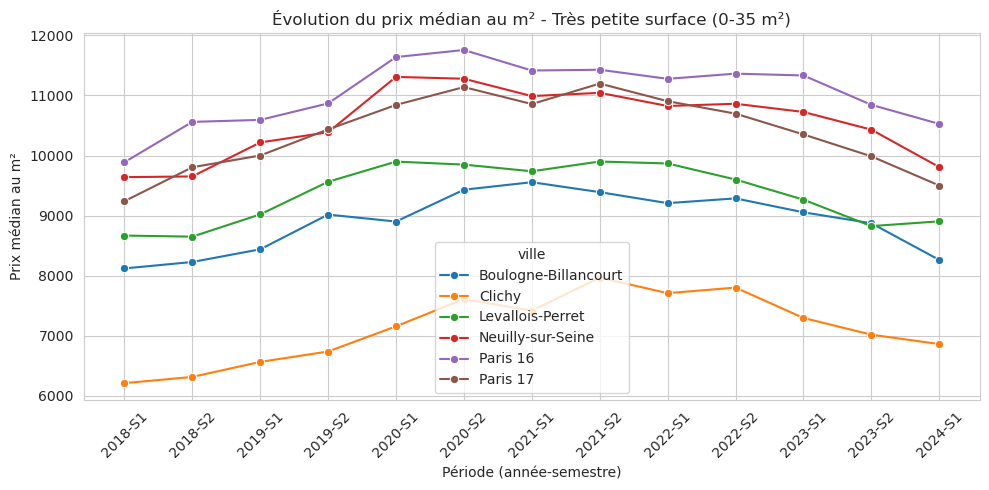

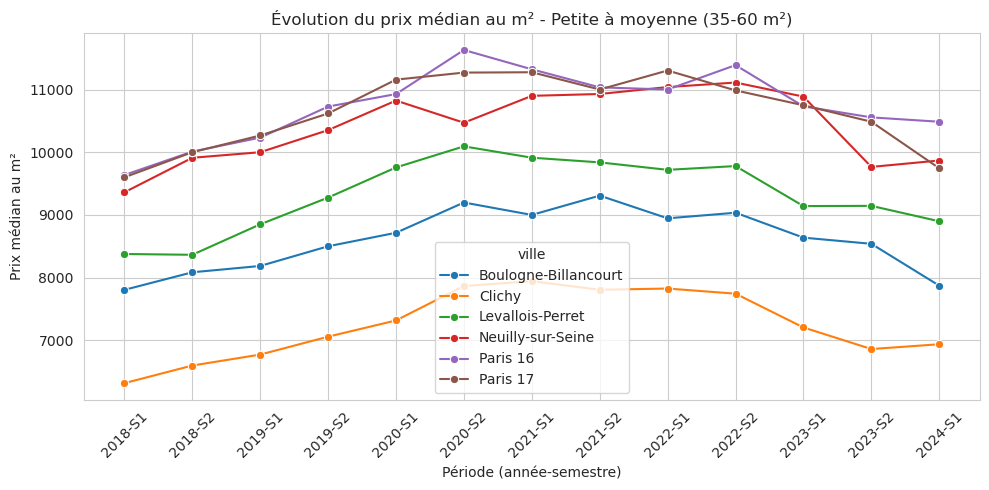

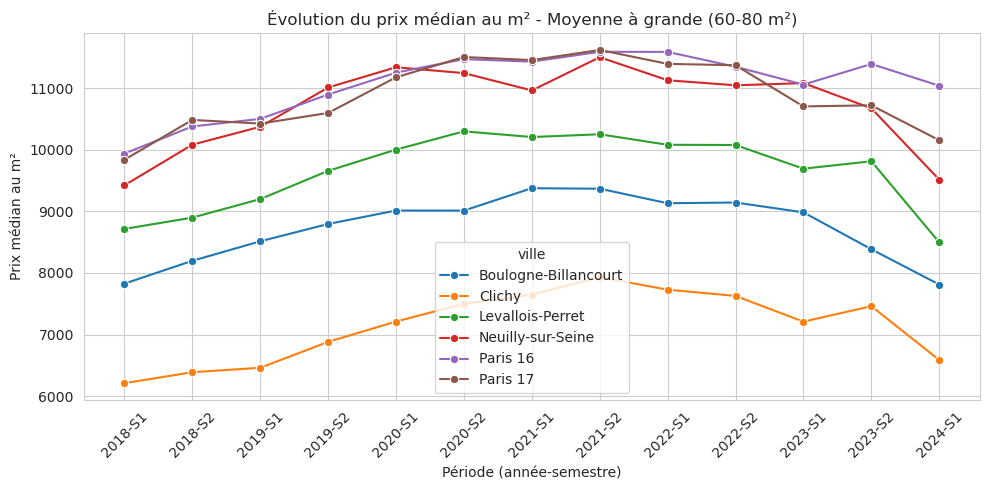

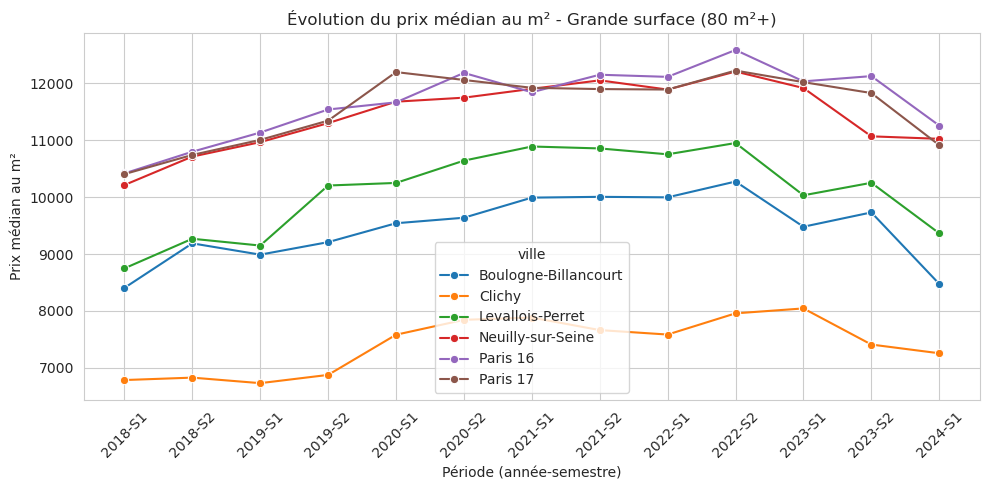

In [193]:
categories = zone_ouest_grouped['categorie_surface'].unique()

for cat in categories:
    # Filtrer la catégorie souhaitée
    df_cat = zone_ouest_grouped[zone_ouest_grouped['categorie_surface'] == cat]
    

    
    plt.figure(figsize=(10,5))
    sns.lineplot(
        data=df_cat,
        x='periode',
        y='prix_m2_median',
        hue='ville',
        marker='o'
    )
    plt.title(f"Évolution du prix médian au m² - {cat}")
    plt.xlabel("Période (année-semestre)")
    plt.ylabel("Prix médian au m²")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


On s'intéresse désormais à l'évolution du nombre de transactions par ville. 

In [195]:
transactions_par_categorie = (
    zone_ouest
    .groupby(["annee", "semestre", "ville", "categorie_surface"])["idmutinvar"]
    .nunique()  # Comptage des mutations uniques
    .reset_index()
    .rename(columns={"idmutinvar": "nb_transactions"})
)

transactions_par_categorie['periode'] = (
    transactions_par_categorie['annee'].astype(str)
    + '-S'
    + transactions_par_categorie['semestre'].astype(str)
)
transactions_par_categorie.sort_values(["annee", "semestre"], inplace=True)

# Vérifier un aperçu des données calculées
print(transactions_par_categorie.head())



   annee  semestre                 ville              categorie_surface  \
0   2018         1  Boulogne-Billancourt  Très petite surface (0-35 m²)   
1   2018         1  Boulogne-Billancourt    Petite à moyenne (35-60 m²)   
2   2018         1  Boulogne-Billancourt    Moyenne à grande (60-80 m²)   
3   2018         1  Boulogne-Billancourt        Grande surface (80 m²+)   
4   2018         1                Clichy  Très petite surface (0-35 m²)   

   nb_transactions  periode  
0              210  2018-S1  
1              285  2018-S1  
2              179  2018-S1  
3              175  2018-S1  
4              155  2018-S1  


/tmp/ipykernel_55739/2537703957.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["annee", "semestre", "ville", "categorie_surface"])["idmutinvar"]


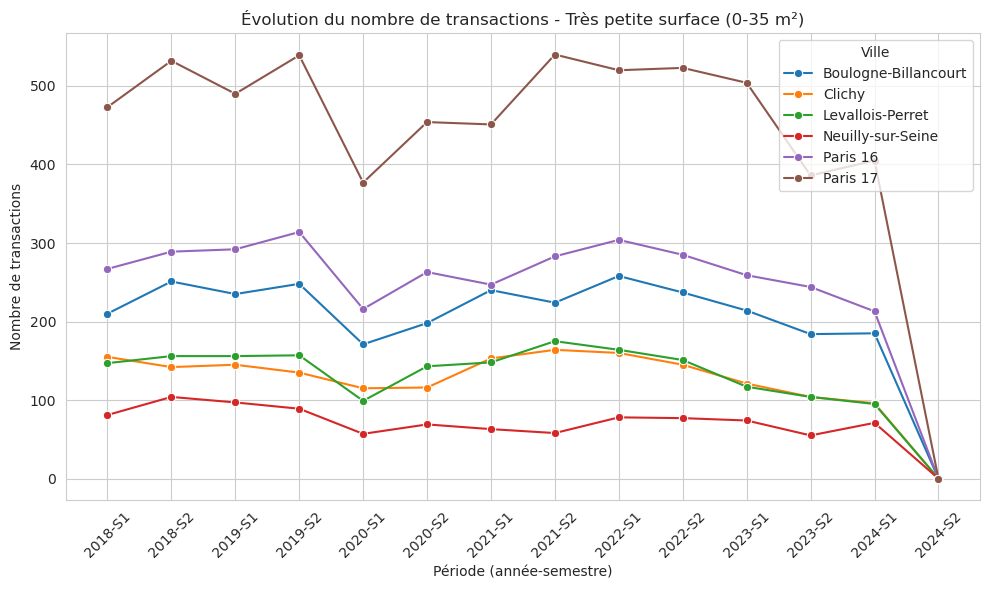

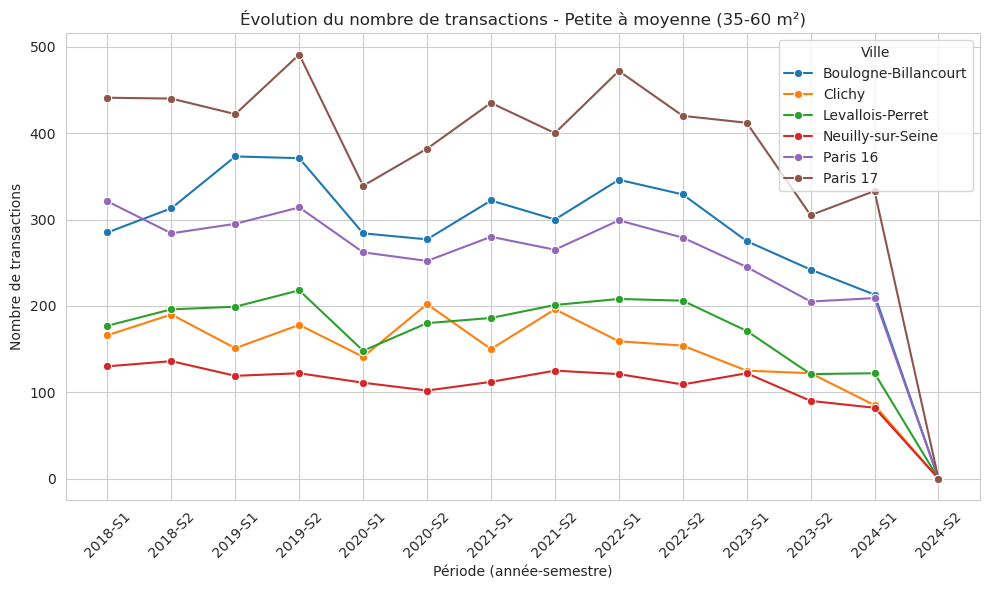

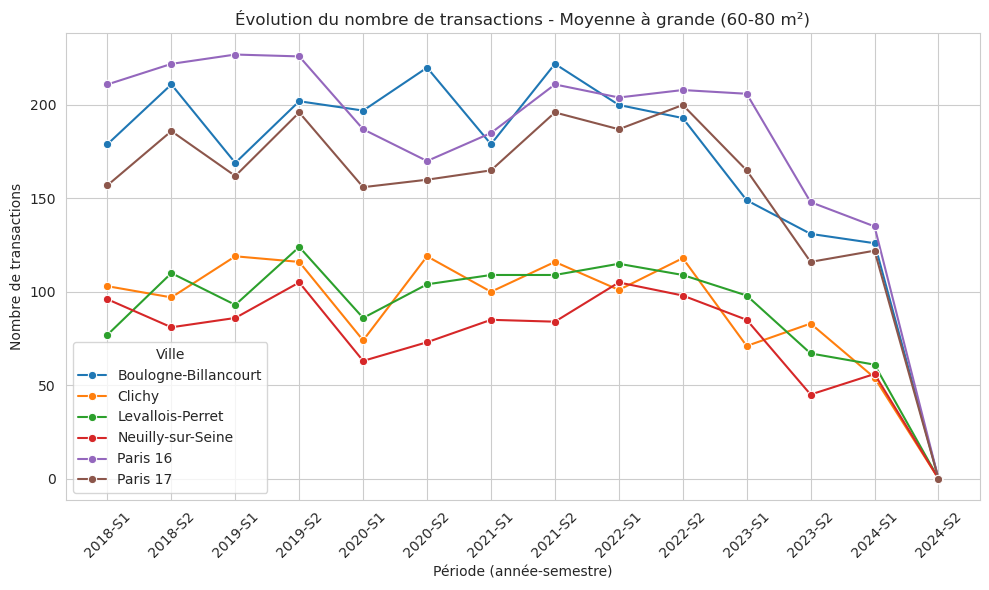

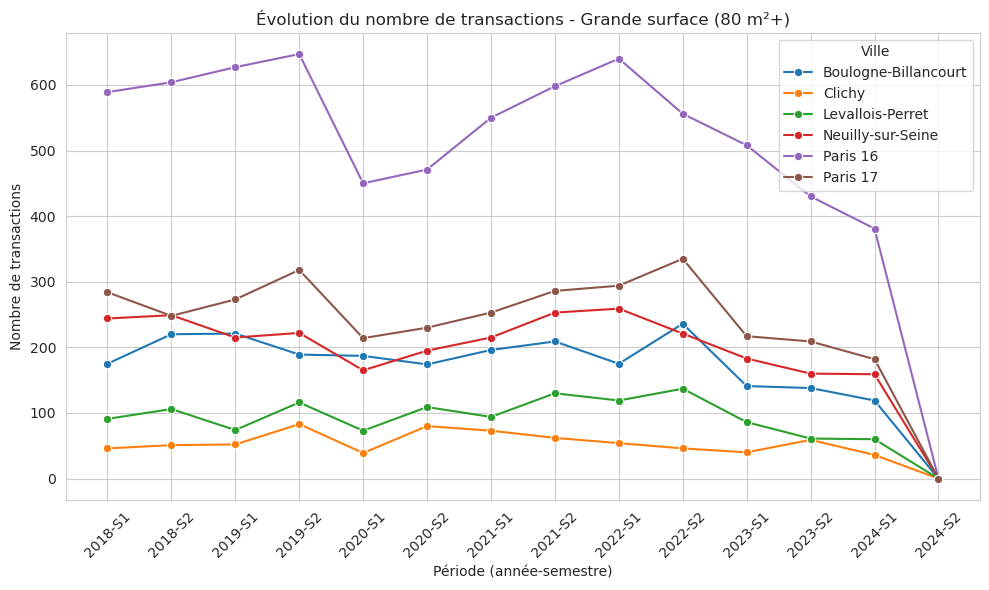

In [196]:

categories = transactions_par_categorie['categorie_surface'].unique()

for cat in categories:
    # Filtrer la catégorie de surface
    df_cat = transactions_par_categorie[transactions_par_categorie['categorie_surface'] == cat]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_cat,
        x="periode",
        y="nb_transactions",
        hue="ville",
        marker="o"
    )
    plt.title(f"Évolution du nombre de transactions - {cat}")
    plt.xlabel("Période (année-semestre)")
    plt.ylabel("Nombre de transactions")
    plt.xticks(rotation=45)
    plt.legend(title="Ville")
    plt.tight_layout()
    plt.show()


Désormais on souhaite voir une évolution plus globale des prix médians au mètre carré. Encadrement de la variable "encadrement" correspond à Paris 16 et Paris 17 où l'encadrement des loyers a été appliqué tandis qu'il ne l'est pas pour les autres villes mentionnées précédemment.

In [205]:
zone_ouest['encadrement'] = np.where(
    zone_ouest['ville'].isin(["Paris 16", "Paris 17"]),
    "Encadrement",     # Valeur si la commune est dans la liste
    "Hors encadrement" # Valeur sinon
)


In [206]:
zone_ouest_grouped = (
    zone_ouest
    .groupby(["annee", "semestre", "categorie_surface", "encadrement"])["prix_m2"]
    .median()
    .reset_index()
    .rename(columns={"prix_m2": "prix_m2_median"})
)


/tmp/ipykernel_55739/2070924932.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["annee", "semestre", "categorie_surface", "encadrement"])["prix_m2"]


In [207]:
zone_ouest_grouped['periode'] = (
    zone_ouest_grouped['annee'].astype(str)
    + '-S'
    + zone_ouest_grouped['semestre'].astype(str)
)

# Trier pour être sûr de l'ordre chronologique (facultatif, mais recommandé)
zone_ouest_grouped.sort_values(["annee","semestre"], inplace=True)


On remarque d'abord que le prix médian évolue sensiblement de la même manière dans les villes encadrées et non encadrées sans filtrer par catégories de surface.

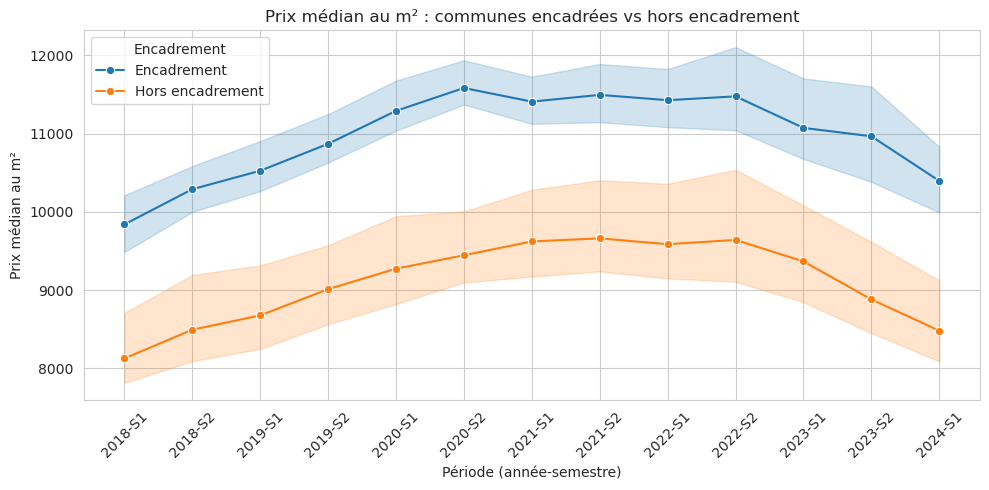

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.lineplot(
    data=zone_ouest_grouped,
    x='periode',
    y='prix_m2_median',
    hue='encadrement',  # seulement 2 courbes ici
    marker='o'
)
plt.xticks(rotation=45)
plt.title("Prix médian au m² : villes encadrées vs non encadrées")
plt.xlabel("Période par semestre)")
plt.ylabel("Prix médian au m²")
plt.legend(title="Encadrement")
plt.tight_layout()
plt.show()


On regarde l'évolution du prix médian au mètre carré par catégorie de 6 mois en filtrant par catégorie de surface.

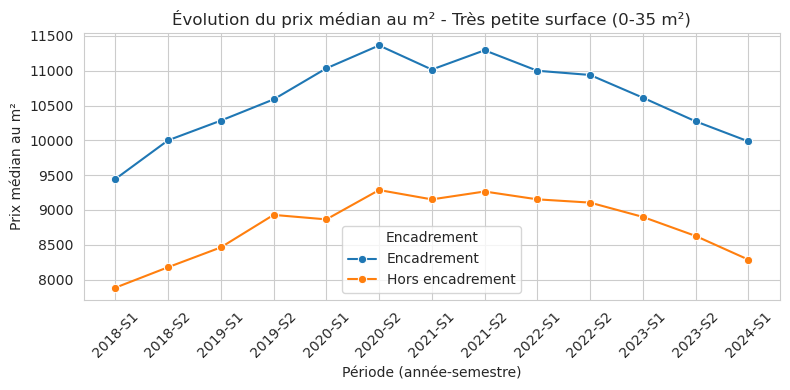

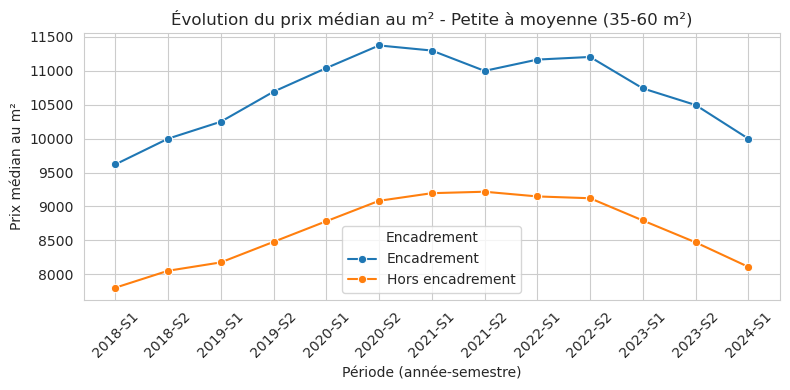

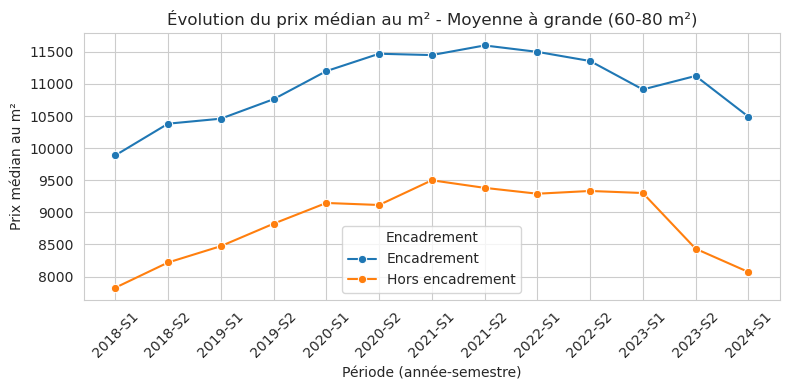

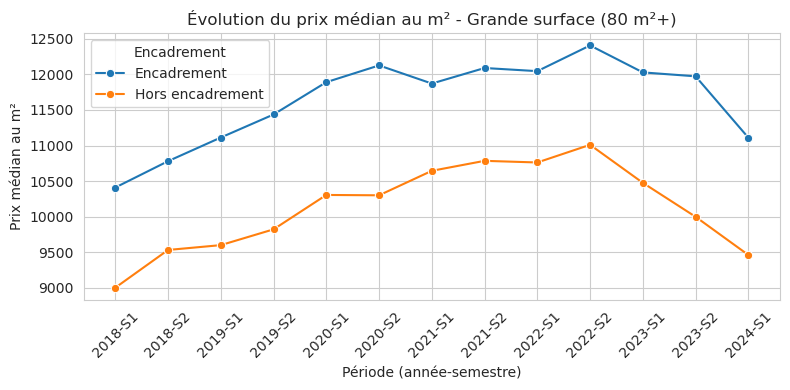

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = zone_ouest_grouped['categorie_surface'].unique()

for cat in categories:
    df_cat = zone_ouest_grouped[zone_ouest_grouped['categorie_surface'] == cat]
    
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=df_cat,
        x='periode',
        y='prix_m2_median',
        hue='encadrement',  # 2 courbes : Encadrement / Hors encadrement
        marker='o'
    )
    plt.title(f"Évolution du prix médian au m² - {cat}")
    plt.xlabel("Période (année-semestre)")
    plt.ylabel("Prix médian au m²")
    plt.xticks(rotation=45)
    plt.legend(title="Encadrement")
    plt.tight_layout()
    plt.show()


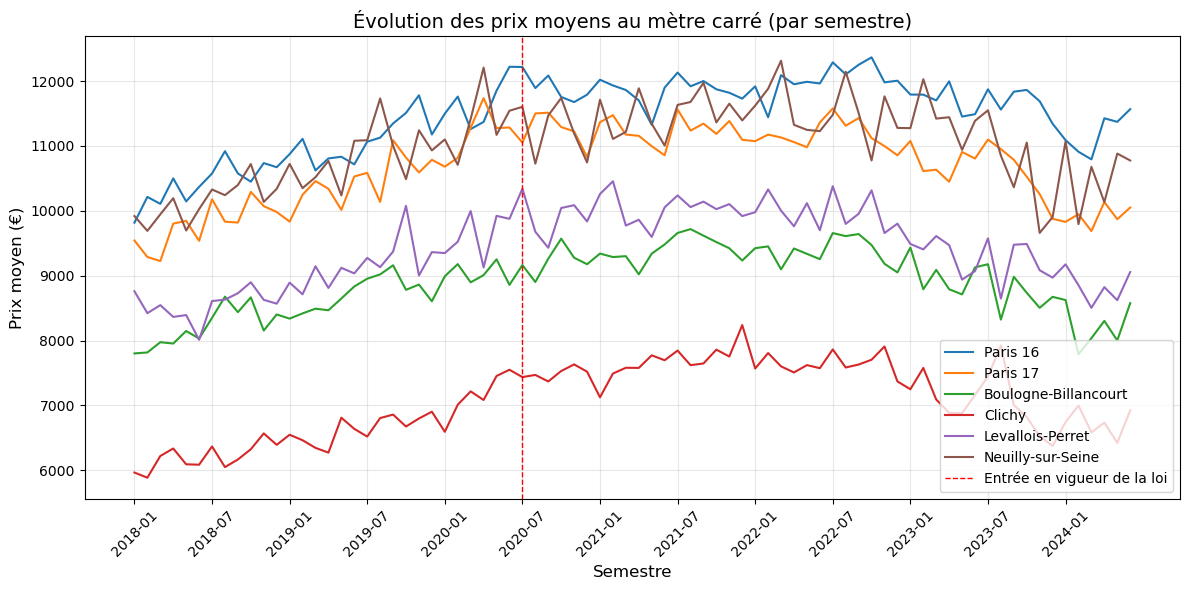

In [ ]:
plt.figure(figsize=(12, 6))

evolution_prix_semestre = evolution_prix_semestre[evolution_prix_semestre['semestre'] >= '2018-01']

# Tracer les courbes des prix moyens pour chaque ville
for ville in zone_ouest['ville'].unique():
    data_ville = evolution_prix_semestre[evolution_prix_semestre['ville'] == ville]
    plt.plot(data_ville['semestre'].astype(str), data_ville['Prix moyen (€)'], label=f'{ville}', linewidth=1.5)

# Ligne pour l'entrée en vigueur de la loi
plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")

# Ajustement des ticks pour espacer de 6 mois (1 tick sur 6)
ticks = evolution_prix_semestre['semestre'].astype(str).unique()
plt.xticks(ticks=ticks[::6], rotation=45)  # Un tick tous les 6 mois
plt.title("Évolution des prix moyens au mètre carré (par semestre)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Prix moyen (€)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()







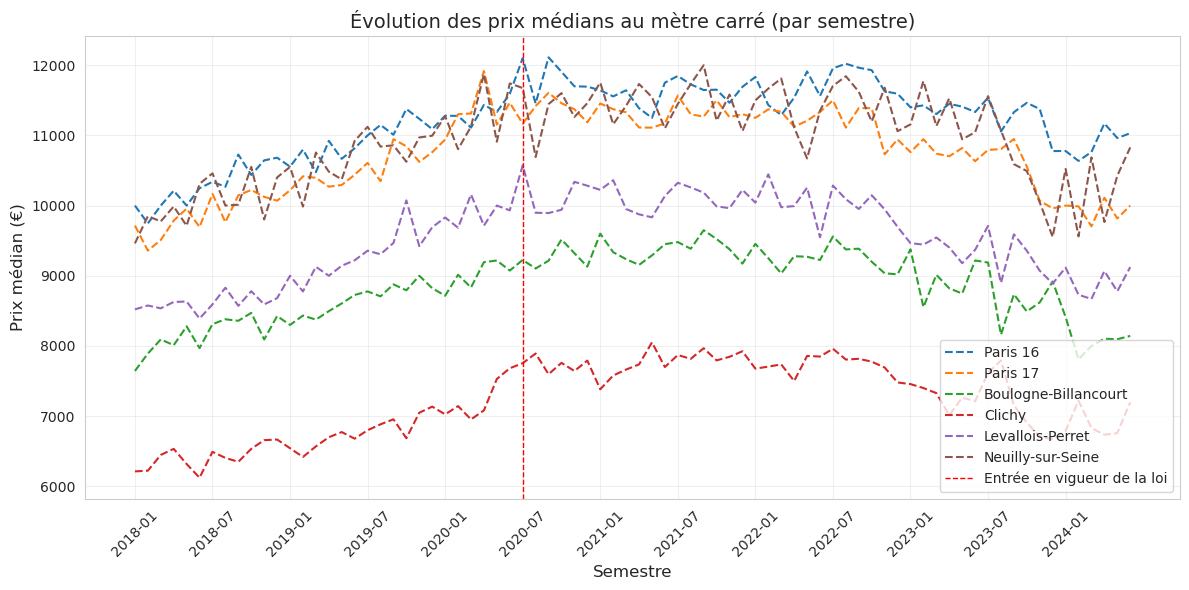

In [ ]:
plt.figure(figsize=(12, 6))

# Tracer les courbes des prix médians pour chaque ville
for ville in zone_ouest['ville'].unique():
    data_ville = evolution_prix_semestre[evolution_prix_semestre['ville'] == ville]
    plt.plot(data_ville['semestre'].astype(str), data_ville['Prix médian (€)'], label=f'{ville}', linewidth=1.5, linestyle='--')

plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")

ticks = evolution_prix_semestre['semestre'].astype(str).unique()
plt.xticks(ticks=ticks[::6], rotation=45)
plt.title("Évolution des prix médians au mètre carré (par semestre)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Prix médian (€)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [ ]:
zone_ouest['encadrement_loyers'] = zone_ouest['ville'].apply(
    lambda x: 'Soumis' if x in ['Paris 16', 'Paris 17'] else 'Non soumis'
)
evolution_par_groupe = zone_ouest.groupby(['semestre', 'encadrement_loyers'])['prix_m2'].agg(['median', 'mean']).reset_index()
evolution_par_groupe.rename(columns={'median': 'Prix médian (€)', 'mean': 'Prix moyen (€)'}, inplace=True)


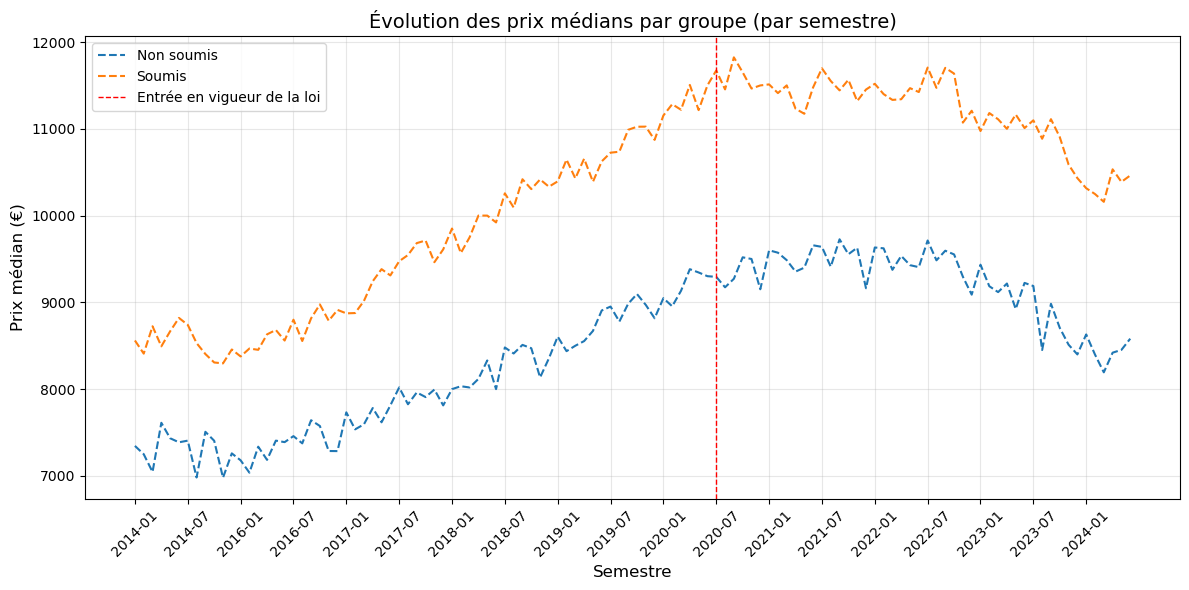

In [ ]:
plt.figure(figsize=(12, 6))

for groupe in evolution_par_groupe['encadrement_loyers'].unique():
    data_groupe = evolution_par_groupe[evolution_par_groupe['encadrement_loyers'] == groupe]
    plt.plot(data_groupe['semestre'].astype(str), data_groupe['Prix médian (€)'], label=f'{groupe}', linewidth=1.5, linestyle='--')

plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")

ticks = evolution_par_groupe['semestre'].astype(str).unique()
plt.xticks(ticks=ticks[::6], rotation=45)
plt.title("Évolution des prix médians par groupe (par semestre)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Prix médian (€)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [ ]:
# Calculer la différence des prix médians entre les groupes
difference_prix = evolution_par_groupe.pivot(index='semestre', columns='encadrement_loyers', values='Prix médian (€)')
difference_prix['Différence des prix médians (€)'] = difference_prix['Soumis'] - difference_prix['Non soumis']
difference_prix.reset_index(inplace=True)



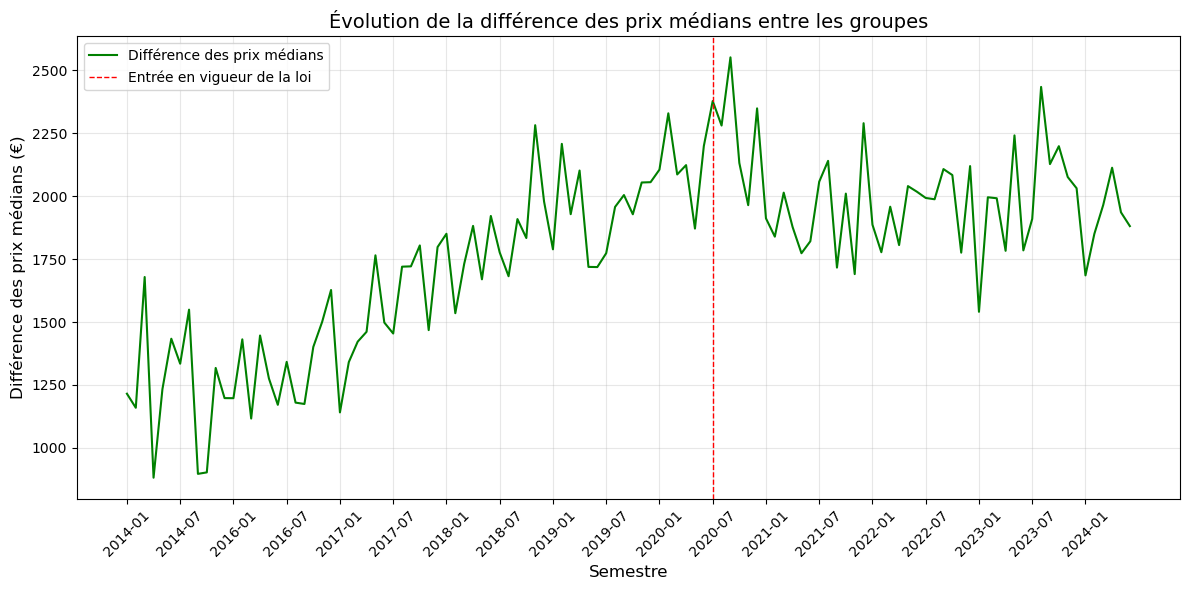

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(difference_prix['semestre'].astype(str), difference_prix['Différence des prix médians (€)'], label="Différence des prix médians", linewidth=1.5, color='green')


plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")


plt.title("Évolution de la différence des prix médians entre les groupes", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Différence des prix médians (€)", fontsize=12)
plt.xticks(ticks=difference_prix['semestre'].astype(str)[::6], rotation=45)  # Espacement des ticks tous les 6 mois
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
# Calcul du nombre de transactions par semestre et par ville
transactions_par_zone = zone_ouest.groupby(['semestre', 'ville'])['idmutinvar'].count().reset_index()
transactions_par_zone.rename(columns={'idmutinvar': 'Nombre de transactions'}, inplace=True)


print(transactions_par_zone.head())


  semestre                 ville  Nombre de transactions
0  2014-01  Boulogne-Billancourt                     124
1  2014-01                Clichy                      28
2  2014-01      Levallois-Perret                      67
3  2014-01     Neuilly-sur-Seine                      57
4  2014-01              Paris 16                     170


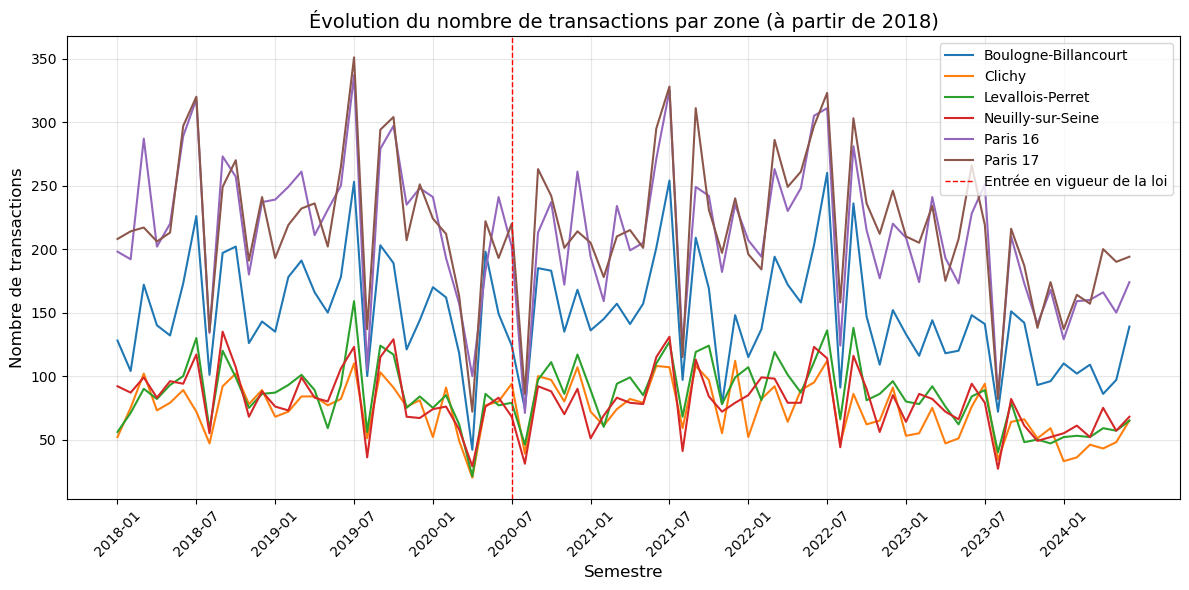

In [ ]:
plt.figure(figsize=(12, 6))

transactions_par_zone_2018 = transactions_par_zone[transactions_par_zone['semestre'] >= '2018-01']


for ville in transactions_par_zone_2018['ville'].unique():
    data_ville = transactions_par_zone_2018[transactions_par_zone_2018['ville'] == ville]
    plt.plot(data_ville['semestre'].astype(str), data_ville['Nombre de transactions'], label=f'{ville}', linewidth=1.5)

plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")


ticks = transactions_par_zone_2018['semestre'].astype(str).unique()
plt.xticks(ticks=ticks[::6], rotation=45)


plt.title("Évolution du nombre de transactions par zone (à partir de 2018)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()



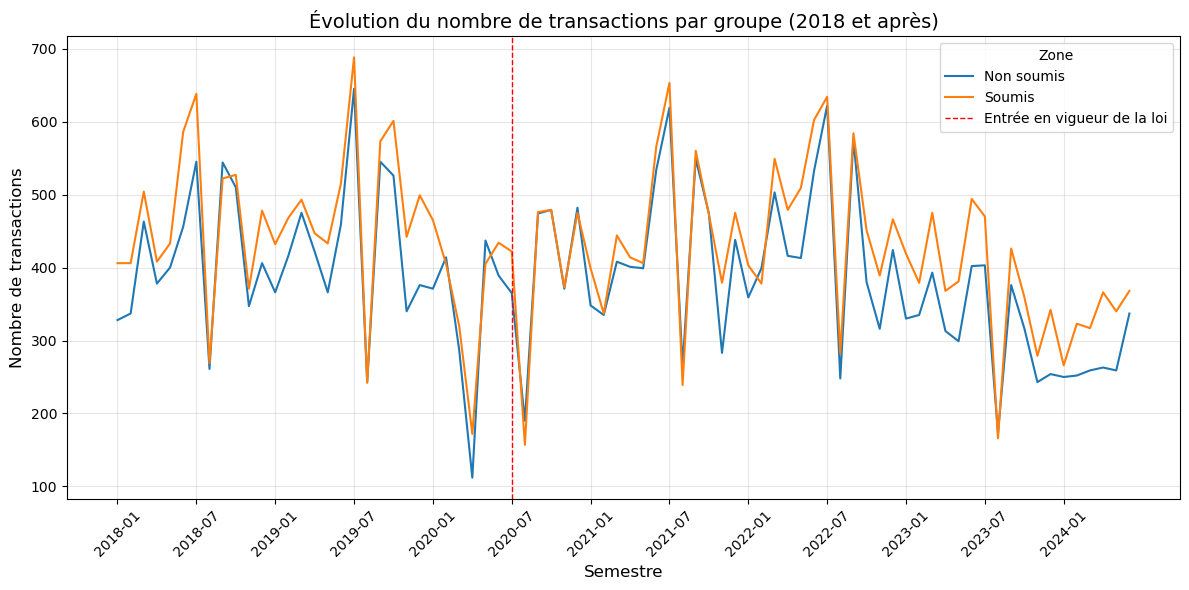

In [ ]:
plt.figure(figsize=(12, 6))


transactions_par_groupe = zone_ouest.groupby(['semestre', 'encadrement_loyers'])['idmutinvar'].count().reset_index()
transactions_par_groupe.rename(columns={'idmutinvar': 'Nombre de transactions'}, inplace=True)

transactions_par_groupe = transactions_par_groupe[transactions_par_groupe['semestre'] >= '2018-01']

for groupe in transactions_par_groupe['encadrement_loyers'].unique():
    data_groupe = transactions_par_groupe[transactions_par_groupe['encadrement_loyers'] == groupe]
    plt.plot(data_groupe['semestre'].astype(str), data_groupe['Nombre de transactions'], label=f'{groupe}', linewidth=1.5)

plt.axvline(x='2020-07', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")

ticks = transactions_par_groupe['semestre'].astype(str).unique()
plt.xticks(ticks=ticks[::6], rotation=45)


plt.title("Évolution du nombre de transactions par groupe (2018 et après)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.legend(title="Zone", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


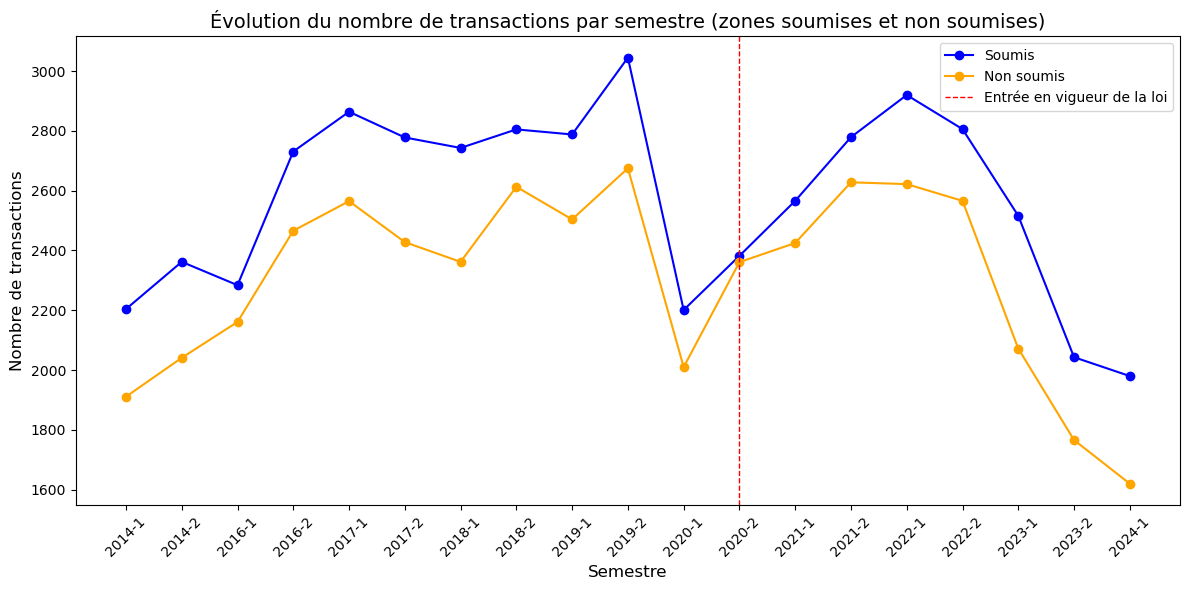

In [ ]:

plt.figure(figsize=(12, 6))

plt.plot(
    transactions_pivot.index, transactions_pivot['Soumis'],
    label="Soumis", color="blue", marker="o"
)


plt.plot(
    transactions_pivot.index, transactions_pivot['Non soumis'],
    label="Non soumis", color="orange", marker="o"
)


plt.axvline(x='2020-2', color='red', linestyle='--', linewidth=1, label="Entrée en vigueur de la loi")


plt.title("Évolution du nombre de transactions par semestre (zones soumises et non soumises)", fontsize=14)
plt.xlabel("Semestre", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.xticks(rotation=45)
plt.legend()

#
plt.tight_layout()
plt.show()


In [ ]:
prix_medians_6m = (
    zone_ouest.groupby(['periode_6m', 'encadrement_loyers'])['prix_m2']
    .median()
    .reset_index()
    .pivot(index='periode_6m', columns='encadrement_loyers', values='prix_m2')
    .rename(columns={True: 'Soumis', False: 'Non soumis'})
    .reset_index()
)

print(prix_medians_6m.head())



encadrement_loyers periode_6m   Non soumis       Soumis
0                      2014-1  7357.894737  8580.330490
1                      2014-2  7250.000000  8461.538462
2                      2016-1  7259.500000  8548.437500
3                      2016-2  7448.989796  8837.209302
4                      2017-1  7682.352941  9129.733520


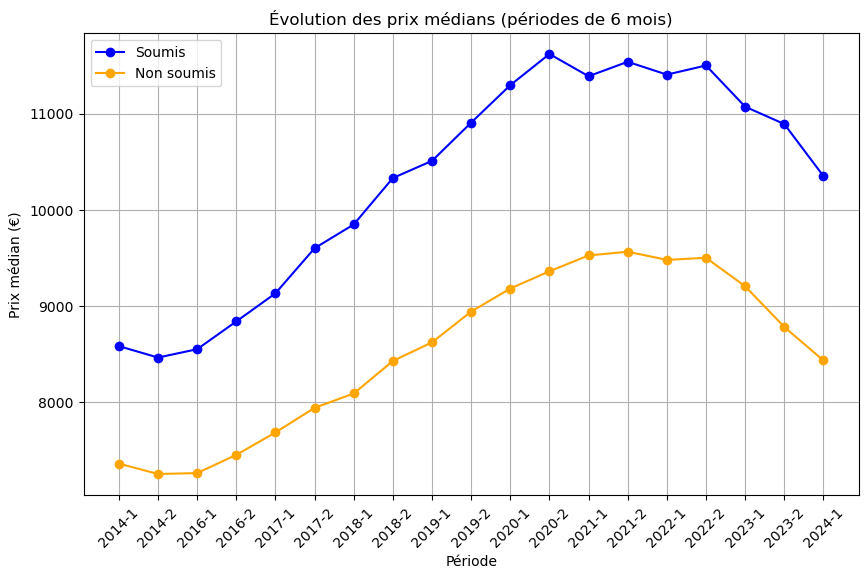

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(prix_medians_6m['periode_6m'].astype(str), prix_medians_6m['Soumis'], label='Soumis', marker='o', color='blue')
plt.plot(prix_medians_6m['periode_6m'].astype(str), prix_medians_6m['Non soumis'], label='Non soumis', marker='o', color='orange')
plt.title("Évolution des prix médians (périodes de 6 mois)")
plt.xlabel("Période")
plt.ylabel("Prix médian (€)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


